#### Analysis of multiple stocks - for simulation over the course of n years at variable buy in frequency

Goal: This script simulates any number (typically 2) years of n-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through a series of overlapping cycles of variable length, creating a linear prediction to be applied. Assess the theoretical performance of adjusting contributions as compared to contributing a consistent amount over time.

This script only uses stock opening price and no other external variables. TBD introduction of other info.


Limitations:

This script should be able to imitate any amount time using a series of strategies, given enough stock history available. The main misleading results this will give compared to paper trading is in choosing stocks and pretending you've been interested in them for n years.

In [301]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date
import math
from sys import exit
import time

# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

ymd = str(date.today().year) + str(date.today().month).zfill(2) + str(date.today().day).zfill(2)
ymd


'20220209'

In [302]:
"""
##### Current: Revisions 6: Dynamic Baseline

### Doing
test strategy against raw data to confirm numbers
    against opt 5 and opt5_db
dynamic baseline based on 260 day regression
    make it 6 months instead? Or 3 months?
    test validity of the new strategy - high rise = buy more? less?
    test - does a stock split effect the slope?
    is the strategy really sound?
test all the strategies on multiple conditions
    make it 6 months instead? Or 3 months?
    good stocks, random stocks, known bad stocks
    ending high, ending low
    investing 1 year, investing 2 years
        export all results
        decide on a strategy (probably opt5 or opt5_db)


### To do
Fix the section of the functions where ensuring you don't hit max spending is calculated
after baseline optimization is solid - try to wrench it into the original dictionary so I don't have to do it all twice
    or do 2 dictionaries keep things flexible?
test trading mon morn vs all other weekday mornings
fix the error when 1 only stock is run
what other yfinance data available?
fix the copy errors - do it right
be able to do any unit of time, not just days - make it 'units' of time
    so I can check on hypothetical minute to minute trading
    might take a total branch off this script
Start testing buy/sell every period based on a set budget
    will likely be a big job. maybe a lot of changes needed
    will possibly need to make it it's own script
    I do still want to compare to a standard buy and hold consistently approach as the baseline
create a bare bones version that just quickly says today's invest prices
Add functions
    Define a function for each strategy. Opt1, opt2 etc. Should be able to get them down to a few variables
create a strategy to find the ideal stocks to put bigger baseline investments into
fix the v variable aspect of the invest options. Will matter if I want to cap the max invest
bring in more predictor variables
    Find a better R^2 at a significant P-val and all that
    Should be easy to altar the current model - do it this week




### Fixed/Done
are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
Fix the final statement to say profit/loss or above/below dynamically
    seems to have an issue with the reversal of percents when the total profits are negative
    need to test with net loss stocks
Test for different 3 year periods of time
Fact check the dynamic dates - is everything really working?
I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
    I can't actually trust this method until I do this
    probably means actually using time series instead of the index replacement -- nope
be able to run on SP500
    SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
error checking on too much history run
    have a whole section dedicated to it and say which stock and by how much it misses
Make a path to DL data and call to it again w/o issues
    For flights w/o internet
be able to do one stock at a time -- OR be able to bypass
3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
    invest_weeks must be an integer
    re-check all new facets of weeks and invest_weeks
convert 'y' years of data to be 'w?' weeks.
    calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
make the invest period dynamic
make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix
swap to open instead of open, it's more true to my practice
I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
    I need to pick a series of random stocks and see if I still beat baseline
Add individual buy in prices. 
    Do a 2 variable loop along with my j stock variable? Do a pre logic to pick custom buy ins or make all the same if only one chosen
get opt5 ready or some other method
something wrong with the last table output - opt 5, when pred/open2 > 1.2
    the df data are ok, but this needs to be fixed ASAP
add in flight 1 and flight 2 of biweekly options
find BTC data - must do
    either through another package or manual DL and upload
    does the fact that BTC is daily mess up the code?
optimize the code that creates the pred calculation. Only the last row in each dictionary entry is used
replace most recent day entry with a to the minute entry
    suspect at 0630, the last day's value is assigned for a bit
    problem since I don't want to use Friday's open price on Monday morn
fix running the btc option
dynamic baseline based on 260 day regression - get it running
fix the stock vs crypto vs index issue
    Why is index different again? only has closing maybe?
Make a new list of random stocks that works - has enough history
make a series of new options with dynamic baseline
fix the summary stuff so I don't have to make new lines for every new strategy
fix the list contrib multiplier. did I delete it?
is my final profit output not normalized for investment? fix it if so

"""
print('complete')

complete


In [303]:
start = time.perf_counter()

Set options

In [304]:
##### User choices go here #####

### choose stocks, crypto, or index
# index option is because the day's open prices aren't available at 630am. Otherwise, index funds can be called a stock
trade_type = 'stock'
# trade_type = 'crypto'
# trade_type = 'index'

### choose stocks of interest
# stocks chosen must all have data for full range of dates
stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
# stock_list = ['BTC-USD', 'ETH-USD']
# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['VFIAX', 'VTIAX', 'VTSAX']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['FDX', 'TFC', 'DCI', 'DIS', 'MDLZ', 'ROST', 'MDT', 'RTX', 'V'] # random-ish stocks

### choose how much to contribute each weekly period
# may choose a single value for all stocks or a set of tailored values per stock
contrib_amt = [5.00, 3.75, 2.50, 1.25, 2.50, 3.75, 2.50, 3.75, 2.50, 2.50, 2.50, 5.00, 3.75] # for core list new
# contrib_amt = [10]
# contrib_amt = [5]
# contrib_amt = [350, 50, 100] # for 3 index list

### use this to allot total baseline contrib to all stocks instead of choosing each stock
baseline_total_contrib = 40

### strategies to visualize
d_list = [' baseline', ' baseline_db', ' opt2', ' opt2_db', ' opt5', ' opt5_db', ' opt6', ' opt6_db', ' opt7', ' opt7_db', ' opt8']

### weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

### invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 1

### number of days to roll into each linear regression.
# 260 = ~1 year, 65 = ~1 quarter, 21 = ~1 month (remember, a trading week is a bit less than 5 days on average)
roll_days = 65

### number of days to determine dynamic baseline
baseline_roll_days = 130


### opt 5 + 6: threshold of consistent buying vs increased buying
buyvalue = 1.2

### opt 7: threshold of consistent buying vs increased buying
buyvalue2 = 1

### opt 5: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier = 3

### opt 6: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * multiplier)
multiplier2 = 4

### opt 7: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier3 = 1.5

### max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
# unlimited max is another viable strategy
invest = float('inf')
# invest = contrib_amt*invest_weeks



##### 'choices' that should really be left alone #####

# number of years to visualize
if trade_type == 'crypto':
    day_hist = (total_weeks*7)+baseline_roll_days+1 # choose for crypto ~ trading every day
else:
    day_hist = (total_weeks*5)+baseline_roll_days+1 # choose for stocks ~ trading about 5 days per week

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)


print('Total invest amount over', total_weeks, 'weeks:', invest)
print('Number of invest weeks:', invest_weeks)
print('Days of data to pull:', day_hist)


Total invest amount over 104 weeks: inf
Number of invest weeks: 104
Days of data to pull: 651


In [305]:
# duplicate contrib_amt for all stocks if only 1 listed
if len(contrib_amt) == len(stock_list):
    pass
elif len(contrib_amt) == 1: 
    contrib_amt = [contrib_amt[0] for x in enumerate(stock_list)]
else:
    print('Incorrect length of contrib_amt. Make it match the length of the stock list or be 1 value')
    exit()

contrib_amt

[5.0, 3.75, 2.5, 1.25, 2.5, 3.75, 2.5, 3.75, 2.5, 2.5, 2.5, 5.0, 3.75]

Pull data

In [306]:
# check every 15 seconds for complete data
# wait times should only happen for ~1-2 minutes after market open on trading days (right after 0630am PST)

if trade_type == 'crypto' or trade_type == 'index':
  pass
else:
  x = 0
  while x < 1:
    df_now = yf.download(
      tickers = stock_list
      ,period = '1d' # set for 'today' instead
      ,interval = '1m'
    )
        
    df_now = df_now.head(1) # open for today
    df_now = df_now.fillna(0)

    # df_now['Open', 'AAPL'] = 0 # force a 0 for testing

    x = 1
    for i in stock_list:
      x = x * int(df_now['Open'][i])

    if x == 0: # wait 15 seconds if data aren't complete
      time.sleep(15)
    else:
      if df_now.index.day == date.today().day:
        print('Datetime of data available: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
      else:
        print('Warning, today\'s data not yet available')

  df_now['Open']

# When compared to later in the day, open prices are a few cents off. Seems fine. Much better than pretending Friday open is the Monday open
# Datetime of data available:  January 28, 2022 06:31:36
# Datetime of data available:  January 31, 2022 06:31:27
# Datetime of data available:  February 01, 2022 06:31:05
# Datetime of data available:  February 02, 2022 06:31:11
# Datetime of data available:  February 03, 2022 06:31:15
# Datetime of data available:  February 07, 2022 06:31:07


[*********************100%***********************]  13 of 13 completed
Datetime of data available:  February 09, 2022 20:31:06


In [307]:
# check the traditional open price
df_open_check = yf.download(
    tickers = stock_list
    # ,start = '2022-01-15'
    # ,end = '2022-01-18'
    ,period = str(day_hist) + 'd'
)
df_open_check['Open'].tail(2)

[*********************100%***********************]  13 of 13 completed


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
Date,,,,,,,,,,,,,
2022-02-08,171.729996,122.379997,3135.010010,215.600006,2779.824951,47.980000,301.250000,243.589996,353.959991,95.290001,101.910004,905.530029,122.000000
2022-02-09,176.050003,129.600006,3257.469971,221.139999,2816.995117,49.330002,309.869995,256.220001,363.760010,96.250000,104.809998,935.000000,124.879997


In [308]:
### Overly complex way to pull data, but I have found that 'Open' prices are just a copy of the previous day for the first few minutes of the trading day
### This method pulls in the true Open prices for today much quicker (a couple minutes after 6:30am PST)

if trade_type == 'crypto' or trade_type == 'index':
    df = yf.download(
        tickers = stock_list
        # ,start = '2022-01-15'
        # ,end = '2022-01-18'
        ,period = str(day_hist) + 'd'
    )
else:
    # Pull all data except for today
    df_bulk = yf.download(
            tickers = stock_list
            # ,start = '2022-01-15'
            # ,end = '2022-01-18'
            ,period = str(day_hist) + 'd'
        )
    df_good_index = df_bulk.copy() # used to grab the ideal index
    df_bulk.drop(df_bulk.tail(1).index,inplace=True) # bulk w/o the most recent day

    # join the data (index is still bad)
    df = pd.concat([df_bulk, df_now])

    # sub in a good index
    df = df.reindex_like(df_good_index)

    # sub in good open data for today
    for i in stock_list:
        df['Open', i][len(df)-1] = df_now['Open', i].copy()
        
df['Open']

[*********************100%***********************]  13 of 13 completed


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
Date,,,,,,,,,,,,,
2019-07-15,51.022499,33.340000,2021.400024,158.759995,1146.859985,50.000000,139.440002,42.115002,193.979996,89.870003,82.480003,49.599998,41.750000
2019-07-16,51.147499,34.299999,2010.579956,159.960007,1146.000000,49.910000,138.960007,41.667500,193.910004,90.220001,81.800003,49.860001,41.799999
2019-07-17,51.012501,34.009998,2007.050049,157.679993,1150.969971,49.500000,137.699997,41.787498,193.149994,90.080002,80.209999,51.133999,41.680000
2019-07-18,51.000000,33.029999,1980.010010,157.000000,1141.739990,49.279999,135.550003,42.532501,191.289993,90.330002,80.870003,51.009998,42.520000
2019-07-19,51.447498,33.080002,1991.209961,159.729996,1148.189941,49.959999,140.220001,42.930000,193.740005,91.410004,81.610001,51.138000,43.080002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03,174.479996,120.320000,2834.750000,218.070007,2905.899902,49.250000,309.489990,244.580002,358.529999,96.839996,107.000000,882.000000,121.449997
2022-02-04,171.679993,120.339996,3112.129883,214.990005,2860.340088,47.860001,300.209991,239.720001,354.079987,95.410004,102.489998,897.219971,120.440002
2022-02-07,172.860001,123.559998,3170.399902,219.000000,2874.179932,48.130001,306.170013,243.720001,358.619995,95.349998,106.860001,923.789978,122.559998


In [309]:
# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Open']
    df = df[[stock_list[0]]]
else:
    df = df['Open']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/Exports/stocks_raw_export_{ymdt}.csv')
    # df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/stocks_raw_export_{ymdt}.csv')
except:
    print('Can\'t export data')

df


No stock history issues seen


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,,,,,,,
2019-07-15,51.022499,33.340000,2021.400024,158.759995,1146.859985,50.000000,139.440002,42.115002,193.979996,89.870003,82.480003,49.599998,41.750000,1,2019-07-15,0,1,0
2019-07-16,51.147499,34.299999,2010.579956,159.960007,1146.000000,49.910000,138.960007,41.667500,193.910004,90.220001,81.800003,49.860001,41.799999,2,2019-07-16,1,1,0
2019-07-17,51.012501,34.009998,2007.050049,157.679993,1150.969971,49.500000,137.699997,41.787498,193.149994,90.080002,80.209999,51.133999,41.680000,3,2019-07-17,2,1,0
2019-07-18,51.000000,33.029999,1980.010010,157.000000,1141.739990,49.279999,135.550003,42.532501,191.289993,90.330002,80.870003,51.009998,42.520000,4,2019-07-18,3,1,0
2019-07-19,51.447498,33.080002,1991.209961,159.729996,1148.189941,49.959999,140.220001,42.930000,193.740005,91.410004,81.610001,51.138000,43.080002,5,2019-07-19,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-03,174.479996,120.320000,2834.750000,218.070007,2905.899902,49.250000,309.489990,244.580002,358.529999,96.839996,107.000000,882.000000,121.449997,647,2022-02-03,3,134,0
2022-02-04,171.679993,120.339996,3112.129883,214.990005,2860.340088,47.860001,300.209991,239.720001,354.079987,95.410004,102.489998,897.219971,120.440002,648,2022-02-04,4,134,0
2022-02-07,172.860001,123.559998,3170.399902,219.000000,2874.179932,48.130001,306.170013,243.720001,358.619995,95.349998,106.860001,923.789978,122.559998,649,2022-02-07,0,135,1


In [310]:
# make a list of indices that are the Mondays where the trade should take place
# always starting with the most recent Monday

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[649, 644, 639, 635, 630, 625, 620, 616, 611, 606, 601, 597, 592, 587, 582, 577, 572, 567, 562, 557, 552, 547, 543, 538, 533, 528, 523, 518, 513, 508, 503, 499, 494, 489, 484, 479, 475, 470, 465, 460, 455, 450, 445, 440, 435, 431, 426, 421, 416, 411, 406, 402, 397, 392, 387, 383, 378, 373, 369, 365, 360, 355, 350, 346, 341, 336, 331, 326, 321, 316, 311, 306, 301, 296, 292, 287, 282, 277, 272, 267, 262, 257, 252, 247, 243, 238, 233, 228, 223, 219, 214, 209, 204, 199, 194, 189, 185, 180, 175, 170, 165, 160, 155, 151]
Number of weeks picked: 104


Transform data

In [311]:
df_baseline_source = df.copy()

In [312]:
# create 1 dataframe per invest week in a dictionary, each the length of the chosen invest period
# 0 is the most recent

dataframes = {}

# for j in stock_list:
for i in range(invest_weeks):
    x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
    y = nth_wk[i]

    dataframes['data' + str(i)] = df.iloc[x:y]

# print(dataframes['data0'])
# print(dataframes['data' + str(invest_weeks-1)])

In [313]:
# create pred and pred/open list for each of the n dataframes
# sub in -1 for all calc except the last row. Only the last row of each item in the dictionary will be used

for j in stock_list:
    for e in range(len(dataframes)):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][j]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            if i == len(dataframes['data0']):
                x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
                m, b = np.polyfit(x, y, 1)
                d = m*i+b
                nlist.append(d)
            else:
                nlist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][j + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/open
            if i == len(dataframes['data0']):
                d = (dataframes['data' + str(e)][j + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][j].iloc[i-1])
                ylist.append(d)
            else:
                ylist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][j + ' pred/open'] = ylist

# dataframes['data0']


C:\Users\james\AppData\Local\Temp/ipykernel_10048/1052084976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][j + ' pred'] = nlist
C:\Users\james\AppData\Local\Temp/ipykernel_10048/1052084976.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][j + ' pred/open'] = ylist


In [314]:
# pull the last 'open' and pred/open' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last open price in a given period and the final pred/open derived from the linear trendline

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []

    for e in reversed(range(len(dataframes))):
        nlist.append(dataframes['data' + str(e)][j + ' pred/open'].iloc[roll_days-1])
        ylist.append(dataframes['data' + str(e)][j].iloc[roll_days-1])
        zlist.append(dataframes['data' + str(e)][j + ' pred'].iloc[roll_days-1])

    df[j] = pd.DataFrame(ylist)
    df[j + ' pred'] = pd.DataFrame(zlist)
    df[j + ' pred/open'] = pd.DataFrame(nlist)

# df


Transform data - for dynamic baseline

In [315]:
# dictionary for baseline contrib math

dataframes_baseline = {}

# for j in stock_list:
for i in range(invest_weeks):
    x = nth_wk[i]-baseline_roll_days # roll_days sets how many rows in each df
    y = nth_wk[i]

    dataframes_baseline['data' + str(i)] = df_baseline_source.iloc[x:y].copy()

for j in stock_list:
    for i in range(invest_weeks):
        dataframes_baseline['data' + str(i)][j + ' norm'] = dataframes_baseline['data' + str(i)][j].copy()/dataframes_baseline['data' + str(i)][j].iloc[0].copy()

for j in stock_list:
    for e in range(len(dataframes_baseline)):
        nlist = []
        ylist = []
        y = dataframes_baseline['data' + str(e)][j + ' norm']

        for i in range(1,len(dataframes_baseline['data0'])+1):
            if i == len(dataframes_baseline['data0']):
                x = range(1,baseline_roll_days+1)
                m, b = np.polyfit(x, y, 1)
                # d = m*i+b
                nlist.append(m*1000) # x1000 for easier view. It doesn't change the final math
            else:
                nlist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes_baseline['data' + str(e)][j + ' slope'] = nlist

# dataframes_baseline['data0']


In [316]:
df_baseline = pd.DataFrame()
# add_index = np.arange(1,len(dataframes_baseline)+1)
# df_baseline['Index'] = add_index

for j in stock_list:
    nlist = []

    for e in reversed(range(len(dataframes_baseline))):
        nlist.append(dataframes_baseline['data' + str(e)][j + ' slope'].iloc[baseline_roll_days-1])

    df_baseline[j] = pd.DataFrame(nlist)

for i, v in enumerate(df_baseline.iloc):
    if np.min(df_baseline.iloc[i]) > 0:
        df_baseline.iloc[i] = df_baseline.iloc[i] - np.min(df_baseline.iloc[i]) # add the min stock of the series (smallest will be 0)
    else: 
        df_baseline.iloc[i] = df_baseline.iloc[i] + abs(np.min(df_baseline.iloc[i]))
    df_baseline.iloc[i] = df_baseline.iloc[i] / np.sum(df_baseline.iloc[i]) # get the ratio (add up to 1)
    df_baseline.iloc[i] = 1 + (df_baseline.iloc[i] * (baseline_total_contrib - len(stock_list))) # get the true baseline buy in price, minimum will be 1


df_baseline.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/Exports/df_baseline_{ymdt}.csv', index = False)

# df_baseline

Visualizations

In [317]:
# shows each investing period, overlapping
### meh, less useful if I can't account for the dynamic investing periods

# for j in stock_list:
#     for i in range(len(dataframes)):
#         x = dataframes['data' + str(i)]['Index']
#         y = dataframes['data' + str(i)][j]
#         plt.plot(x, y)
#         # m, b = np.polyfit(x, y, 1)
#         # plt.plot(x, m*x + b)

#     plt.xlabel(j)
#     plt.show()

In [318]:
# plot only trendlines, every n weeks, each line representing the chosen length of data
# if the movement is too stable, these graphs won't be useable

# for j in stock_list:
#     for i in range(len(dataframes)):
#         x = dataframes['data' + str(i)]['Index']
#         y = dataframes['data' + str(i)][j]

#         m, b = np.polyfit(x, y, 1)
#         plt.plot(x, m*x + b)

    # plt.xlabel(j)
    # plt.show()

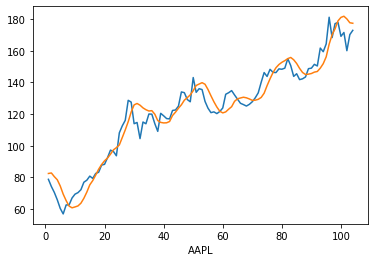

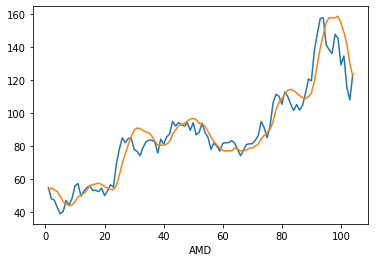

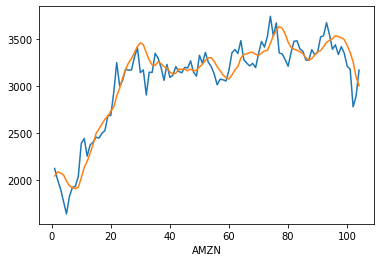

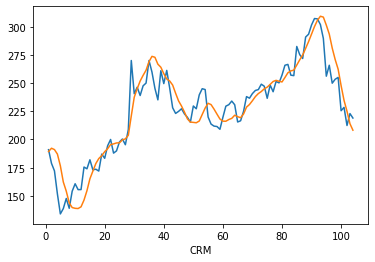

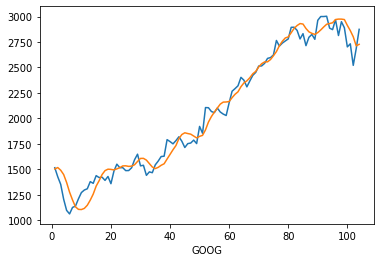

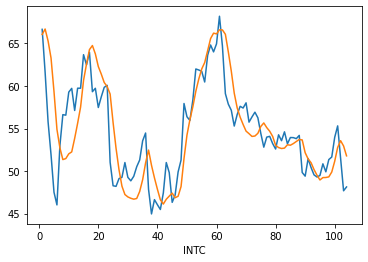

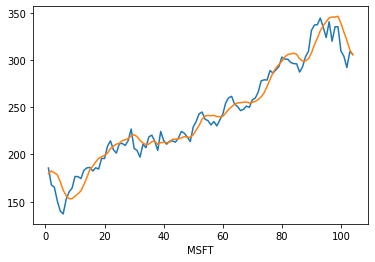

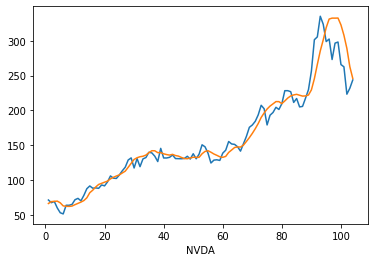

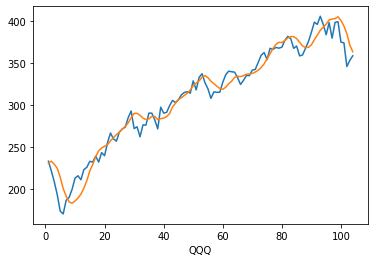

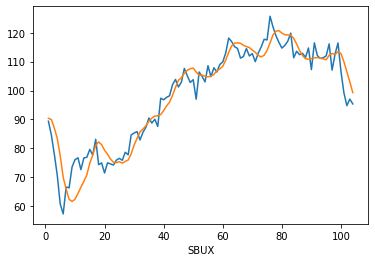

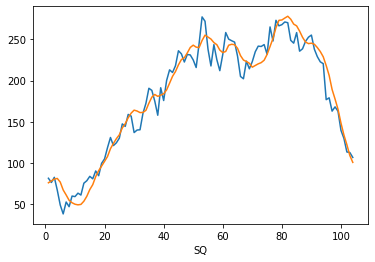

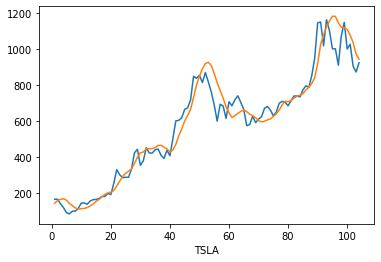

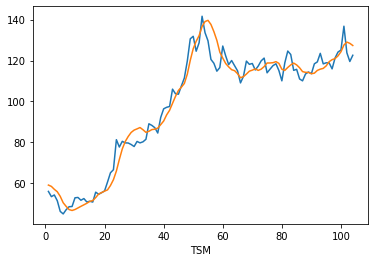

In [319]:
# plot for each stock the open price and the prediction price
# open (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [320]:
# determine the weeks where pred/open is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have open to 0 pred/open > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[j + ' pred/open'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[j + ' >1'] = nlist

# square the pred/open number as a more extreme option for calculations

for j in stock_list:
    df[j +' pred/open2'] = df[j +' pred/open']**2 # make the value differences a little more pronounced

# df.tail(10)

In [321]:
# Create all of the strategies to test 

for j, z in zip(stock_list, contrib_amt):
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[j +' baseline'] = 0
    df[j +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' baseline'].iloc[i] = z
        df[j +' baseline_stk'].iloc[i] = df[j +' baseline'].iloc[i]/df[j].iloc[i]
        v -= z
        if v < z:
            break

# baseline - dynamic
    df[j +' baseline_db'] = 0
    df[j +' baseline_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' baseline_db'].iloc[i] = round(df_baseline.iloc[i][j],2)
        df[j +' baseline_db_stk'].iloc[i] = df[j +' baseline_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2)
        if v < round(df_baseline.iloc[i][j],2):
            break
        
# opt1 - buy in every other week but proportionally to the pred/open
    df[j +' opt1'] = 0
    df[j +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt1'].iloc[i] = z * df[j +' pred/open'].iloc[i]
        df[j +' opt1_stk'].iloc[i] = df[j +' opt1'].iloc[i]/df[j].iloc[i]
        v -= z * df[j +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i + 1
        if v < z * df[j +' pred/open'].iloc[t]:
            break

# opt1 - dynamic baseline
    df[j +' opt1_db'] = 0
    df[j +' opt1_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt1_db'].iloc[i] = round(df_baseline.iloc[i][j],2) * df[j +' pred/open'].iloc[i]
        df[j +' opt1_db_stk'].iloc[i] = df[j +' opt1_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * df[j +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * df[j +' pred/open'].iloc[t]:
            break
    
# opt2 - buy in every other week but proportionally to the square of pred/open
    df[j +' opt2'] = 0
    df[j +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt2'].iloc[i] = z * df[j +' pred/open2'].iloc[i]
        df[j +' opt2_stk'].iloc[i] = df[j +' opt2'].iloc[i]/df[j].iloc[i]
        v -= z * df[j +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z * df[j +' pred/open2'].iloc[t]:
            break

# opt2 - dynamic baseline
    df[j +' opt2_db'] = 0
    df[j +' opt2_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt2_db'].iloc[i] = round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i]
        df[j +' opt2_db_stk'].iloc[i] = df[j +' opt2_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[j +' opt3'] = 0
    df[j +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt3'].iloc[i] = z * 2 * df[j +' >1'].iloc[i] 
        df[j +' opt3_stk'].iloc[i] = df[j +' opt3'].iloc[i]/df[j].iloc[i]
        v -= z * 2 * df[j +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z * 2 * df[j +' >1'].iloc[t]:
            break

# opt3 - dynamic baseline
    df[j +' opt3_db'] = 0
    df[j +' opt3_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt3_db'].iloc[i] = round(df_baseline.iloc[i][j],2) * 2 * df[j +' >1'].iloc[i] 
        df[j +' opt3_db_stk'].iloc[i] = df[j +' opt3_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * 2 * df[j +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * 2 * df[j +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/open
# This is more of a validation and will ideally return negative compared to baseline
    df[j +' opt4'] = 0
    df[j +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt4'].iloc[i] = z/df[j +' pred/open'].iloc[i]
        df[j +' opt4_stk'].iloc[i] = df[j +' opt4'].iloc[i]/df[j].iloc[i]
        v -= z/df[j +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z/df[j +' pred/open'].iloc[t]:
            break

# opt4 - dynamic baseline
    df[j +' opt4_db'] = 0
    df[j +' opt4_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[j +' opt4_db'].iloc[i] = round(df_baseline.iloc[i][j],2) / df[j +' pred/open'].iloc[i]
        df[j +' opt4_db_stk'].iloc[i] = df[j +' opt4_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) / df[j +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) / df[j +' pred/open'].iloc[t]:
            break

# opt5
    df[j +' opt5'] = 0
    df[j +' opt5_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue:
            df[j +' opt5'].iloc[i] = z
        else:
            df[j +' opt5'].iloc[i] = round(z * df[j +' pred/open2'].iloc[i] * multiplier,2)
        df[j +' opt5_stk'].iloc[i] = df[j +' opt5'].iloc[i]/df[j].iloc[i]
        v -= z*df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[j +' pred/open2'].iloc[t]:
            break

# opt5_db
    df[j +' opt5_db'] = 0
    df[j +' opt5_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue:
            df[j +' opt5_db'].iloc[i] = round(df_baseline.iloc[i][j],2)
        else:
            df[j +' opt5_db'].iloc[i] = round(round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i] * multiplier,2)
        df[j +' opt5_db_stk'].iloc[i] = df[j +' opt5_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[t]:
            break

# opt6
    df[j +' opt6'] = 0
    df[j +' opt6_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue:
            df[j +' opt6'].iloc[i] = z
        else:
            df[j +' opt6'].iloc[i] = z * multiplier2
        df[j +' opt6_stk'].iloc[i] = df[j +' opt6'].iloc[i]/df[j].iloc[i]
        v -= z*df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z * df[j +' pred/open2'].iloc[t]:
            break

# opt6 - dynamic baseline
    df[j +' opt6_db'] = 0
    df[j +' opt6_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue:
            df[j +' opt6_db'].iloc[i] = round(df_baseline.iloc[i][j],2)
        else:
            df[j +' opt6_db'].iloc[i] = round(df_baseline.iloc[i][j],2) * multiplier2
        df[j +' opt6_db_stk'].iloc[i] = df[j +' opt6_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[t]:
            break

# opt7
    df[j +' opt7'] = 0
    df[j +' opt7_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue2:
            df[j +' opt7'].iloc[i] = z
        else:
            df[j +' opt7'].iloc[i] = round(z * df[j +' pred/open2'].iloc[i] * multiplier3,2)
        df[j +' opt7_stk'].iloc[i] = df[j +' opt7'].iloc[i]/df[j].iloc[i]
        v -= z*df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[j +' pred/open2'].iloc[t]:
            break

# opt7 - dynamic baseline
    df[j +' opt7_db'] = 0
    df[j +' opt7_db_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue2:
            df[j +' opt7_db'].iloc[i] = round(df_baseline.iloc[i][j],2)
        else:
            df[j +' opt7_db'].iloc[i] = round(round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i] * multiplier3,2)
        df[j +' opt7_db_stk'].iloc[i] = df[j +' opt7_db'].iloc[i]/df[j].iloc[i]
        v -= round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < round(df_baseline.iloc[i][j],2) * df[j +' pred/open2'].iloc[t]:
            break


######################## I/P
# for j, z in zip(stock_list, contrib_amt):
# opt8
    df[j +' opt8'] = 0
    df[j +' opt8_sell'] = 0 ############# must track how much I sell. I can just sum the purchases and sales
    df[j +' opt8_stk'] = 0

    v = invest
    stock_non_neg = 0 ########### make sure stock in never negative

    for i in range(len(df)):
        if df[j +' pred/open2'].iloc[i] < buyvalue and df[j +' pred/open2'].iloc[i] > 1/buyvalue: # buy normal
            df[j +' opt8'].iloc[i] = z
        elif df[j +' pred/open2'].iloc[i] > buyvalue: # buy higher
            df[j +' opt8'].iloc[i] = round(z * df[j +' pred/open2'].iloc[i] * multiplier, 2)
        else: # sell option
            df[j +' opt8'].iloc[i] = round(z / 1/df[j +' pred/open2'].iloc[i] * multiplier * -1, 2)
        
        df[j +' opt8_stk'].iloc[i] = df[j +' opt8'].iloc[i]/df[j].iloc[i] # stock gain/loss per week

        stock_non_neg += df[j +' opt8_stk'].iloc[i]
            ######## how to recursively not buy in when the stock will hit negative? maybe set dummy mirror variables?

        v -= z*df[j +' pred/open2'].iloc[i] ### isn't correct for this algorithm, don't worry about it while I'm going with inf invest
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[j +' pred/open2'].iloc[t]:
            break

# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/Exports/stocks_df_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

# df.tail(10)

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Temp/ipykernel_10048/934304854.py:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[j +' opt8_stk'] = 0
C:\Users\james\AppData\Local\Temp/ipykernel_10048/934304854.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [322]:
#df
#df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/data_export.csv', index = False)

View final results

In [323]:
########################## I/P fails with different standard contrib amounts???

print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')
print('opt7 - normal buy in, boosted at high pred/open, smaller multiplier')
print('opt8 - buy/sell')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()
df2 = pd.DataFrame()

for j in stock_list:

    # general set
    for i, v in enumerate(d_list):
        df2['Index'] = np.arange(1,len(d_list)+1)
        df2[j + ' name'] = d_list

    # unique per row set
    bought_temp = []
    stocks_held_temp = []
    profit_temp = []
    for i, v in enumerate(d_list):
        bought_temp.append(round(np.sum(df[j + v]),2))
        stocks_held_temp.append(round(np.sum(df[j + v + '_stk']),4))
        profit_temp.append(round((np.sum(df[j + v + '_stk']) * df[j].iloc[invest_weeks-1]) - np.sum(df[j + v]),2))
    df2[j + ' bought_in'] = bought_temp
    df2[j + ' stocks_held'] = stocks_held_temp
    df2[j + ' profit'] = profit_temp

    # whole row logic set
    df2[j + ' diff'] = -1
    for i, v in enumerate(d_list):
        df2[j + ' diff'].iloc[i] = round(df2[j + ' profit'].iloc[i]-df2[j + ' profit'].iloc[0],2)
    df2[j + ' %_diff'] = round((df2[j + ' diff']/df2[j + ' profit'])*100,2)


# df_bought_in['name'] = d_list
# df_profit['name'] = d_list
# df_diff['name'] = d_list

for j in stock_list:
    df_bought_in[j + ' bought_in'] = df2[j + ' bought_in']
    df_profit[j + ' profit'] = df2[j + ' profit']
    df_diff[j + ' diff'] = df2[j + ' diff']

# df2


baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently
opt7 - normal buy in, boosted at high pred/open, smaller multiplier
opt8 - buy/sell


In [324]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4

# df_bought_in


In [325]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4

# df_profit


In [326]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4

# df_diff[1:]

In [327]:
# final summary calculations

df_summary = pd.DataFrame()

profit_temp = []
core_temp = []
invest_temp = []
invest_over_temp = []
perc_invest_over_temp = []
perc_above_temp = []
norm_profit = []
norm_over_base = []
norm_perc_over_base = []

for i, v in enumerate(d_list):
      df_summary['strategy'] = d_list
      profit_temp.append(round(sum(df_diff.iloc[i]),2))
      core_temp.append(round(sum(df_profit.iloc[i]),2))
      invest_temp.append(round(sum(df_bought_in.iloc[i]),2))
      invest_over_temp.append(round(sum(df_bought_in.iloc[i])-sum(df_bought_in.iloc[0]),2))
      perc_invest_over_temp.append(round((sum(df_bought_in.iloc[i])/sum(df_bought_in.iloc[0])-1)*100,2))
      perc_above_temp.append(round(sum(df_diff.iloc[i])/sum(df_profit.iloc[0])*100,2))
      norm_profit.append(round(sum(df_bought_in.iloc[0])/sum(df_bought_in.iloc[i])*sum(df_profit.iloc[i]),2))
      norm_perc_over_base.append(round((norm_profit[i]/norm_profit[0]-1)*100,2))
      norm_over_base.append(round((sum(df_bought_in.iloc[0])/sum(df_bought_in.iloc[i])*sum(df_profit.iloc[i]))-(sum(df_bought_in.iloc[0])/sum(df_bought_in.iloc[0])*sum(df_profit.iloc[0])),2))

df_summary['investment'] = invest_temp
df_summary['bought in over base'] = invest_over_temp
df_summary['bought in % over base'] = perc_invest_over_temp
df_summary['profit'] = core_temp
df_summary['profit over baseline'] = profit_temp
df_summary['profit % above base'] = perc_above_temp
df_summary['norm profit'] = norm_profit
df_summary['norm profit over base'] = norm_over_base
df_summary['norm profit % over base'] = norm_perc_over_base

df_summary


,strategy,investment,bought in over base,bought in % over base,profit,profit over baseline,profit % above base,norm profit,norm profit over base,norm profit % over base
0,baseline,4290.00,0.00,0.00,1968.32,0.00,0.00,1968.32,0.00,0.00
1,baseline_db,4160.04,-129.96,-3.03,2284.61,316.29,16.07,2355.98,387.66,19.69
2,opt2,4407.61,117.61,2.74,2252.61,284.29,14.44,2192.50,224.18,11.39
3,opt2_db,4326.70,36.70,0.86,2820.24,851.92,43.28,2796.32,828.00,42.07
4,opt5,5884.73,1594.73,37.17,4122.31,2153.99,109.43,3005.19,1036.87,52.68
5,opt5_db,5990.59,1700.59,39.64,5797.59,3829.27,194.55,4151.79,2183.47,110.93
6,opt6,5786.25,1496.25,34.88,3499.97,1531.65,77.82,2594.92,626.60,31.83
7,opt6_db,5817.72,1527.72,35.61,4528.35,2560.03,130.06,3339.22,1370.90,69.65
8,opt7,5891.22,1601.22,37.32,3131.85,1163.53,59.11,2280.62,312.30,15.87
9,opt7_db,5833.85,1543.85,35.99,3987.28,2018.96,102.57,2932.10,963.78,48.96


In [328]:
# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df_summary.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/Exports/stocks_summary_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

In [329]:
now = pd.DataFrame()
opts = [f'# >= {buyvalue}', f'# < {buyvalue}', 'Total', f'Rate of >= {buyvalue}']
now['Method'] = opts

for j in stock_list:
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = 0 
            for k in range(len(df)-1):
                if df[j + ' pred/open2'].iloc[k] >= buyvalue:
                    x += 1
                else:
                    pass
        elif i == 1: 
            x = 0 
            for k in range(len(df)-1):
                if df[j + ' pred/open2'].iloc[k] < buyvalue:
                    x += 1
                else:
                    pass
        elif i == 2:
            x = len(df)   
        elif i == 3:
            y = 0 
            for k in range(len(df)-1):
                if df[j + ' pred/open2'].iloc[k] >= buyvalue:
                    y += 1
                else:
                    pass
            x = round(y/len(df),4)     
        else: -1
        nlist.append(f'{x}')
    now[j] = nlist

now

,Method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,# >= 1.2,9,19,5,10,7,11,4,15,6,9,19,25,6
1,# < 1.2,94,84,98,93,96,92,99,88,97,94,84,78,97
2,Total,104,104,104,104,104,104,104,104,104,104,104,104,104
3,Rate of >= 1.2,0.0865,0.1827,0.0481,0.0962,0.0673,0.1058,0.0385,0.1442,0.0577,0.0865,0.1827,0.2404,0.0577


In [330]:
########################## I/P redo it dynamically

print('Using one of the strategies, most recent Monday\'s buy in values are listed.')

now = pd.DataFrame()

now.index = d_list

for j in stock_list:
    nlist = []
    for i, v in enumerate(d_list):
        nlist.append(round(df[j + v].iloc[invest_weeks-1],2))
    now[j] = nlist

now


Using one of the strategies, most recent Monday's buy in values are listed.


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
baseline,5.00,3.75,2.50,1.25,2.50,3.75,2.50,3.75,2.50,2.50,2.50,5.00,3.75
baseline_db,3.57,3.88,2.72,2.53,2.91,2.70,3.24,4.24,2.97,2.50,1.00,4.57,3.17
opt2,5.26,3.68,2.25,1.13,2.25,4.34,2.49,3.82,2.57,2.71,2.23,5.22,4.05
opt2_db,3.76,3.81,2.44,2.29,2.62,3.13,3.23,4.31,3.05,2.71,0.89,4.77,3.42
opt5,5.00,3.75,2.50,1.25,2.50,3.75,2.50,3.75,2.50,2.50,2.50,5.00,3.75
opt5_db,3.57,3.88,2.72,2.53,2.91,2.70,3.24,4.24,2.97,2.50,1.00,4.57,3.17
opt6,5.00,3.75,2.50,1.25,2.50,3.75,2.50,3.75,2.50,2.50,2.50,5.00,3.75
opt6_db,3.57,3.88,2.72,2.53,2.91,2.70,3.24,4.24,2.97,2.50,1.00,4.57,3.17
opt7,7.89,3.75,2.50,1.25,2.50,6.51,2.50,5.72,3.85,4.06,2.50,7.83,6.07
opt7_db,5.64,3.88,2.72,2.53,2.91,4.69,3.24,6.47,4.58,4.06,1.00,7.15,5.13


In [331]:
# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    now.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/Exports/stocks_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

In [332]:
################## I/P - add dynamic baseline and opt 5 dynamic

print(f'Current setup for active use - opt5: {roll_days = }, pred/open2, {buyvalue = }, {multiplier = }, {invest = }')
print('Most recent Monday\'s buy in values are listed.')

opt0_cost = 0
opt5_cost = 0
opt5_db_cost = 0
for i in stock_list:
    opt0_cost += now.iloc[0][i]
    opt5_cost += now.iloc[5][i]
    opt5_db_cost += now.iloc[6][i]
    
print(f'{opt0_cost:.2f} - baseline total today buy in')
print(f'{opt5_cost:.2f} - opt5 total today buy in')
print(f'{opt5_db_cost:.2f} - opt5_db total today buy in')

now.iloc[[0, 1, 4, 5]]



Current setup for active use - opt5: roll_days = 65, pred/open2, buyvalue = 1.2, multiplier = 3, invest = inf
Most recent Monday's buy in values are listed.
41.25 - baseline total today buy in
40.00 - opt5 total today buy in
41.25 - opt5_db total today buy in


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
baseline,5.00,3.75,2.50,1.25,2.50,3.75,2.50,3.75,2.50,2.5,2.5,5.00,3.75
baseline_db,3.57,3.88,2.72,2.53,2.91,2.70,3.24,4.24,2.97,2.5,1.0,4.57,3.17
opt5,5.00,3.75,2.50,1.25,2.50,3.75,2.50,3.75,2.50,2.5,2.5,5.00,3.75
opt5_db,3.57,3.88,2.72,2.53,2.91,2.70,3.24,4.24,2.97,2.5,1.0,4.57,3.17


In [333]:
print('pred/open2 current values')
for j in stock_list:
    if df[j +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
        print(round(df[j +' pred/open2'].iloc[invest_weeks-1],4), j)
    else:
        print(round(df[j +' pred/open2'].iloc[invest_weeks-1],4), j, '>', buyvalue)

pred/open2 current values
1.0524 AAPL
0.9807 AMD
0.8985 AMZN
0.904 CRM
0.9001 GOOG
1.1578 INTC
0.9965 MSFT
1.0174 NVDA
1.0269 QQQ
1.0839 SBUX
0.8913 SQ
1.0434 TSLA
1.0794 TSM


In [334]:
end = time.perf_counter()
print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print(f'Seconds to run the script: {round(end - start,2)}')

Current date/time:  February 09, 2022 20:31:20
Seconds to run the script: 14.13


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/open is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/open above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
